In [110]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.stats import median_abs_deviation as MAD
from uncertainties import ufloat
from uncertainties.umath import *
from uncertainties import unumpy

def ageprog(m): # Iben and Tutukov (1987)
    return 10*(m**(-2.5))

def Mass_Prog( MwdSun , method = 1 ):
    if method == 1: # Kurtis A. Williams 
        if MwdSun > 0.358:
            M_prog = (MwdSun-0.358)/0.123
            return M_prog
    
def V_I(color): # Harris, 2018
    if unumpy.nominal_values(color) <= 0.68:
        VI = color/ufloat(0.850,0.010)
    elif unumpy.nominal_values(color) > 0.975:
        VI = (color + ufloat(0.039,0.010))/ufloat(0.845,0.031)
    else:
        VI = (color-ufloat(0.091,0.010))/ufloat(0.737,0.031)
    return VI

def M_I(F814W , VI): # Harris, 2018
    if unumpy.nominal_values(VI) <= 1.2:
        mi = F814W
    else:
        mi = F814W - ufloat(0.130,0.002) + ufloat(0.108,0.003)*VI
    return mi

def Mestel(A , mu , M , L , T , R):
    
    t = (0.1287/(A*(mu**(2/7))))*(M**(5/7))/(L)**(5/7) # Tesi Bologna G.Aricò (2014)
    
    return t # Gyrs

# Parte 1: correzione del CMD

I dati utilizzati sono stati ottenuti con HST, che però utilizza filtri diversi da quelli Johnson-Cousin, che servono per la determinazione della temperatura. Quindi è stato necessario correggere i dati grezzi portandoli nel sistema fotometrico di Johnson-Cousin. 

Prima di fare ciò è stato però necessario correggere il dataset per estinzione e assorbimento. 
L'estinzione è stata ottenuta da Blanco (1964) corregendo l'indice E(B-V) = 0.18 ottenuto da Hansen et al. attraverso:

$$ E(V-I) = 1.2\cdot E(B-V) $$

Mentre l'assorbimento è stato ottenuto dai valori dati da (Hansen et al. 2007), e cioè modulo di distanza e distanza:

$$ R_{V} = \mu_{0} + 5 - 5 log_{10}(d) $$

Dopodichè, usando le relazioni date da Harris (2018) si è cambiato sistema fotometrico, chiamando c il colore di HST:

$$ (V-I)_{0} = \begin{cases}
\frac{c}{0.850 \pm 0.010} \quad c \leq 0.68 \\
\\
\frac{c - (0.091 \pm 0.010}{0.737 \pm 0.031} \quad 0.68 < c \leq 0.975 \\
\\
\frac{c + (0.039 \pm 0.010}{0.845 \pm 0.031} \quad c \geq 0.975
\end{cases} $$

$$ m_{I} = \begin{cases}
    F814W \quad (V-I)_{0} \leq 1.2 \\
    \\
    F814W - (0.130\pm 0.002) + (0.108 \pm 0.003)(V-I)_{0} \quad (V-I)_{0} > 1.2
\end{cases} $$

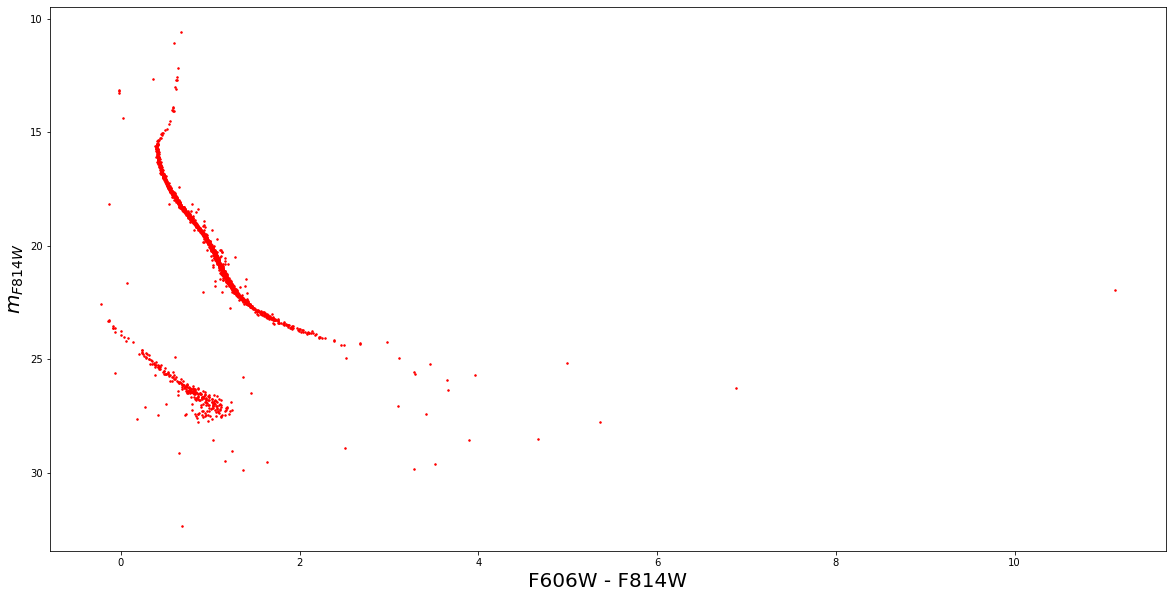

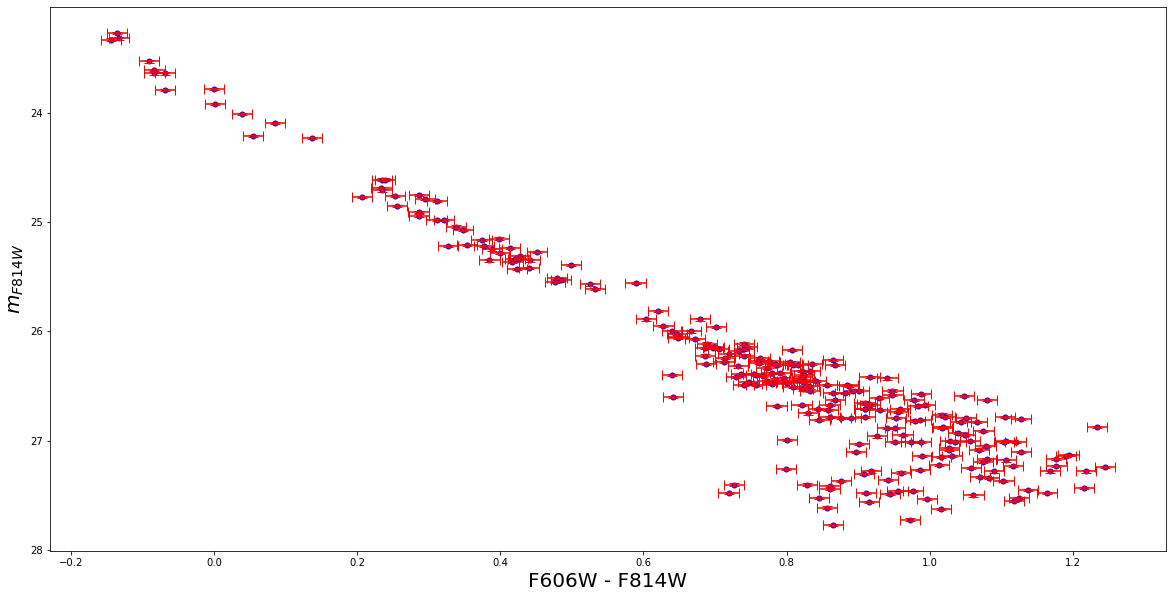

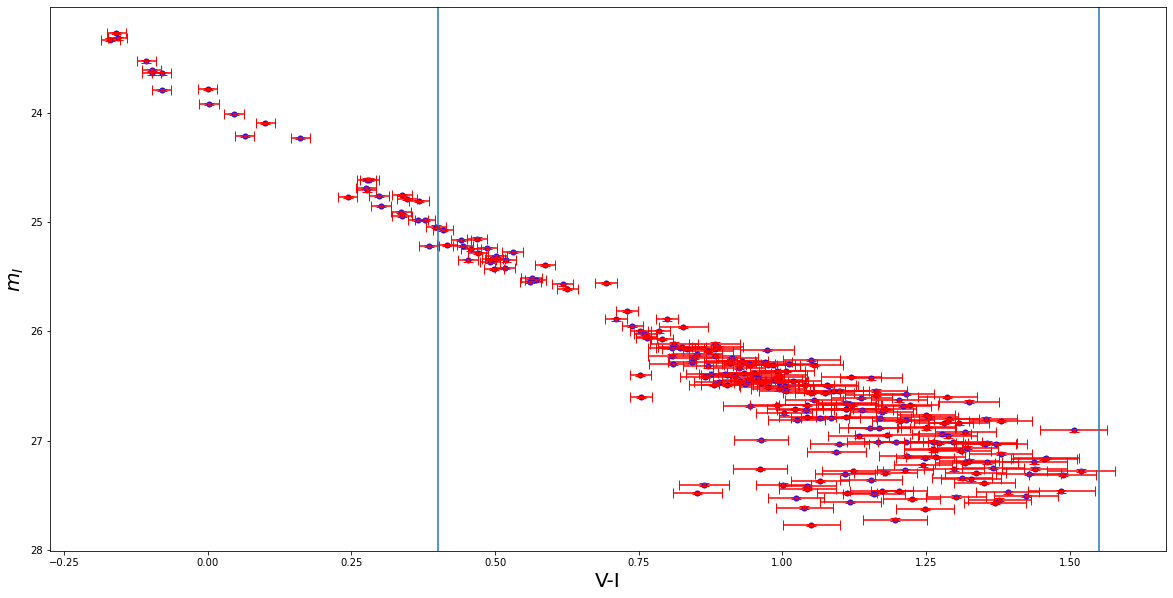

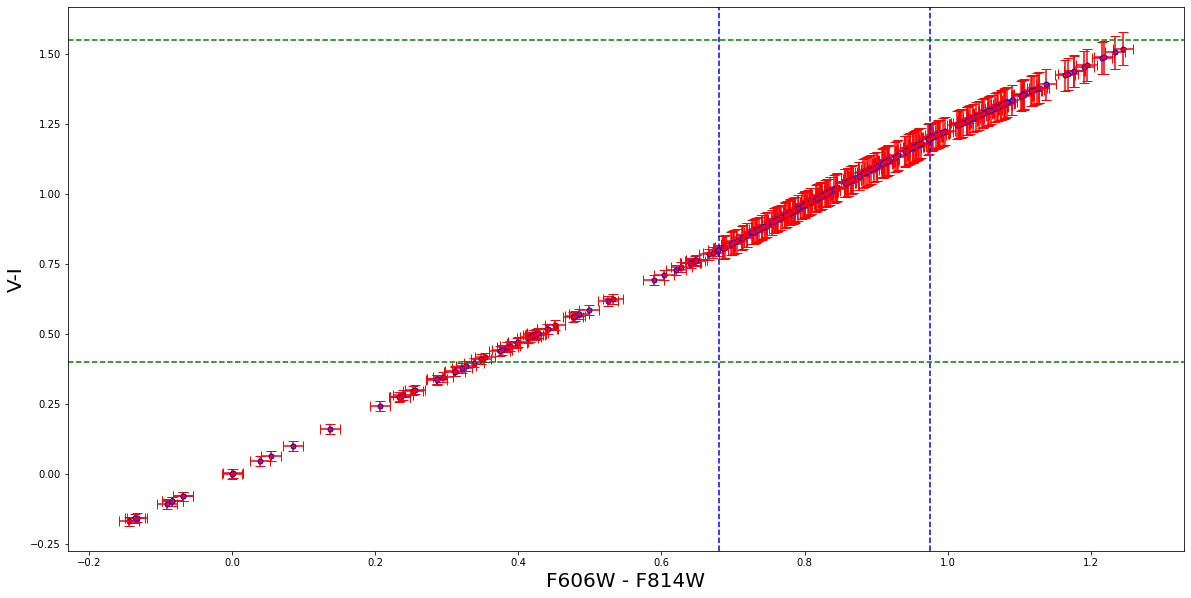

The number of candidate WDs is:  249


In [2]:
E_BV = 0.18
E_VI = 1.2*E_BV #From Victor Blanco (1964)

DATA = np.genfromtxt('NGC6397.txt', comments = '#')

C = DATA[:,4]
MI = DATA[:,3]
dist_modul_0 = ufloat(12.13 , 0.15) # Hansen et al. 2007
d = 10**((dist_modul_0+5)/5) # pc

Ext_Coeff = dist_modul_0 + 5 - 5*log10(d)

MII = []
mII = []

CC = []
MV = np.zeros(len(MI))

for i in range(len(C)):
    
    obs_mi = ufloat(MI[i],0.01) - Ext_Coeff
    cc = ufloat(C[i],np.sqrt(2)*0.01) - ufloat(E_VI,0) 
    
    ABS_MI = obs_mi - 5*log10(d) + 5
    
    CC.append(cc)
    MII.append(ABS_MI)
    mII.append(obs_mi)

plt.figure(figsize = [20,10])
plt.plot( unumpy.nominal_values(CC) , unumpy.nominal_values(mII) , 'r.' , markersize = 3 )
plt.gca().invert_yaxis()
plt.xlabel('F606W - F814W' , fontsize = 20)
plt.ylabel('$m_{F814W}$' , fontsize = 20)
plt.savefig('CMD_total.png')
plt.show()

################### WDs dataset ############################

C_WD = []
MagI = []
appI = []

for i in range(len(CC)):
        
    if MII[i] > 5.3-unumpy.nominal_values(Ext_Coeff)+5 and MII[i] < 12-unumpy.nominal_values(Ext_Coeff)+5 and CC[i] < 1.5-E_VI and CC[i] > 0-E_VI :
        
        if MII[i] < 13 and CC[i] > 0.8:
            continue
        if MII[i] < 13.5 and CC[i] > 0.6:
            continue
        if MII[i] > 13.5 and CC[i] < 0.6:
            continue
        if MII[i] > 16:
            continue
        if MII[i] > 13 and CC[i] < 0:
            continue

        C_WD.append(CC[i])
        MagI.append(MII[i])
        appI.append(mII[i])

plt.figure(figsize = [20,10])
plt.plot(unumpy.nominal_values(C_WD) , unumpy.nominal_values(appI) , 'bo' , markersize = 5)
plt.errorbar(unumpy.nominal_values(C_WD) , unumpy.nominal_values(appI)  
             , yerr = 0.01 , xerr = unumpy.std_devs(C_WD)
             , fmt = '.' , color = 'r' , capsize = 5)
plt.gca().invert_yaxis()
plt.xlabel('F606W - F814W' , fontsize = 20)
plt.ylabel('$m_{F814W}$' , fontsize = 20)
plt.savefig('CMD_HST_WD.png')
plt.show()

########### Johnson-Cousin Band transformation ###################

c_VI = []
m_i = []

plt.figure(figsize = [20,10])
for i in range(len(C_WD)):
    c = V_I(C_WD[i])
    m = M_I(appI[i] , c)
    c_VI.append(c)
    m_i.append(m)
    
plt.plot(unumpy.nominal_values(c_VI) , unumpy.nominal_values(m_i) , 'bo' , markersize = 5)
plt.errorbar(unumpy.nominal_values(c_VI) , unumpy.nominal_values(m_i)  
             , yerr = unumpy.std_devs(m_i) , xerr = unumpy.std_devs(c_VI) 
             , fmt = '.' , color = 'r' , capsize = 5)
plt.gca().invert_yaxis()
plt.xlabel('V-I' , fontsize = 20)
plt.ylabel('$m_{I}$' , fontsize = 20)
plt.savefig('CMD_JC_WD.png')
plt.axvline(0.4)
plt.axvline(1.55)
plt.show()

############# Color-color diagram ################

plt.figure(figsize = [20,10])
for i in range(len(C_WD)):
    c = V_I(C_WD[i])
    plt.plot(unumpy.nominal_values(C_WD[i]) , unumpy.nominal_values(c) , 'bo' , markersize = 5)
    plt.errorbar(unumpy.nominal_values(C_WD[i]) , unumpy.nominal_values(c)  
                 , xerr = unumpy.std_devs(C_WD[i]) , yerr = unumpy.std_devs(c) 
                 , fmt = '.' , color = 'r' , capsize = 5)
plt.ylabel('V-I' , fontsize = 20)
plt.xlabel('F606W - F814W' , fontsize = 20)

plt.axvline(0.68 , linestyle = '--' , color = 'b')
plt.axvline(0.975, linestyle = '--' , color = 'b')

plt.axhline(0.4 , linestyle = '--' , color = 'g')
plt.axhline(1.55 , linestyle = '--' , color = 'g')

plt.savefig('CC_diag.png')
plt.show()

print("The number of candidate WDs is: " , len(MagI))

# Parte 2: Parametri Fisici delle WD

Attraverso il colore espresso in (V-I) è possibile ricavare la temperatura attraverso la relazione empirica data da (Houdashelt and Bell, 1999):

$$ T = (9058.78 \pm 166.72) - (6152 \pm 403.46)(V-I)_{0} + (1987.84 \pm 217.38)(V-I)_{0}^{2} $$

Questa relazione è valida sono per $ 0.4 \leq (V-I)_{0} \leq 1.5 $. Infatti questa relazione riduce del 17.27% il campione totale, passando da 249 a 205 nane bianche.

Il raggio è invece ricavabile dalla relazione data da (Hansen et al. 2007):

$$ R = 10^{7 + \frac{1}{5}(11.63 + \mu_{0}+2.77(V-I)_{0}-m_{I})} $$

A questo punto si possono ricavare la massa e la luminosità delle nane bianche:

$$ M = M_{Ch}\left[\frac{\sqrt{R^{4}M_{Ch}^{\frac{4}{3}}+4}-R^{2}M_{Ch}^{\frac{2}{3}}}{2(0.0126)^{2}}\right]^{\frac{3}{2}} $$

$$ L = 4\pi R^{2}\sigma T^{4} $$

Queste ultime due grandezze sono fondamentali per la legge di Mestel, a cui però serve anche al determinazione della massa del progenitore, nel nostro caso data da K.A.Williams:

$$ M_{prog} = \frac{M - 0.358}{0.123} $$

Avendo quest'ultima è infatti possibile stimare la composizione delle nane bianche, ottenendo così un numero di 20 He-WD e 186 CO-WD.

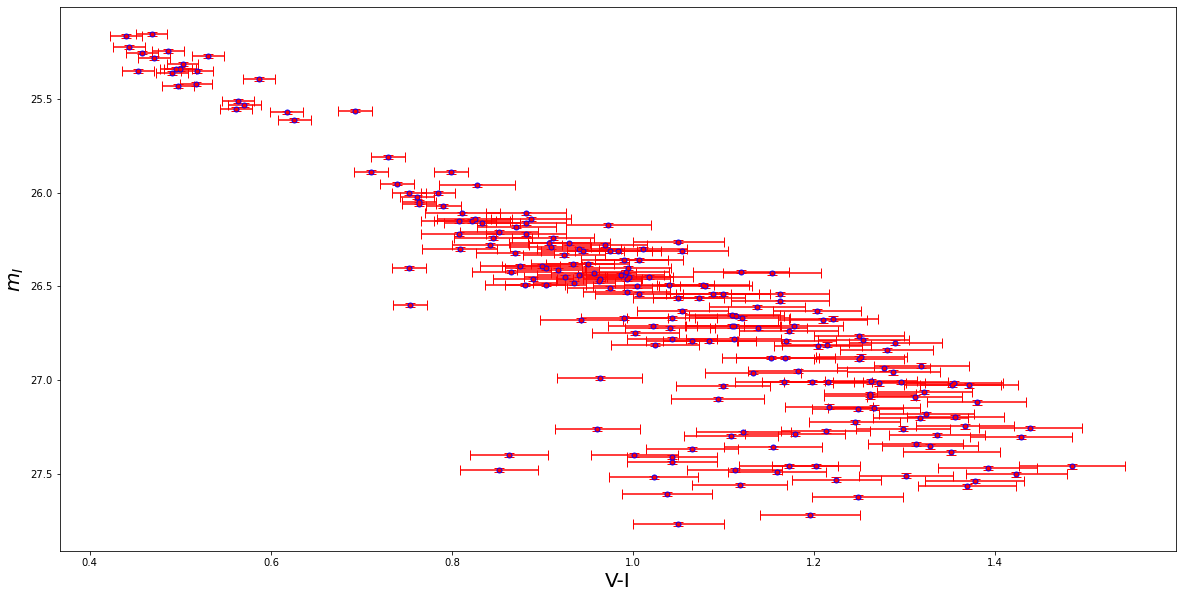

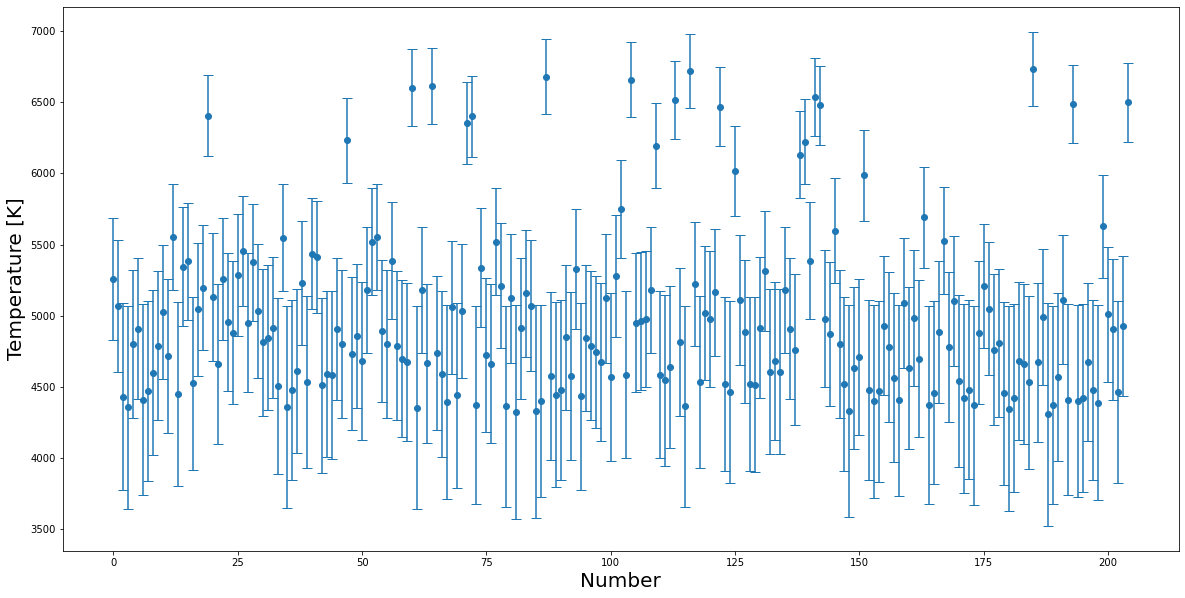

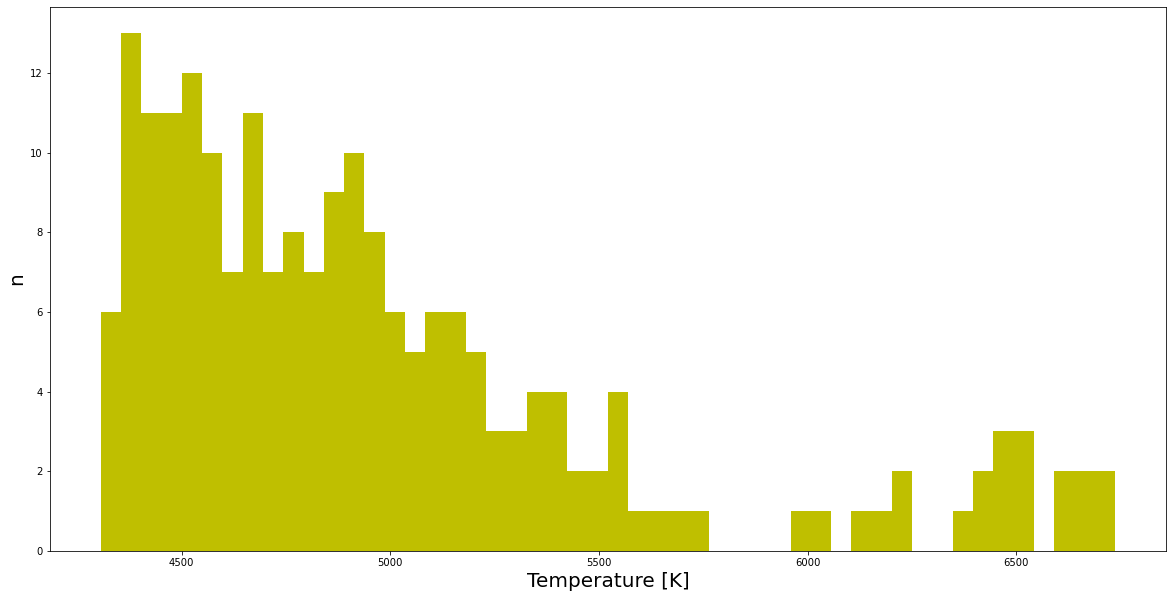

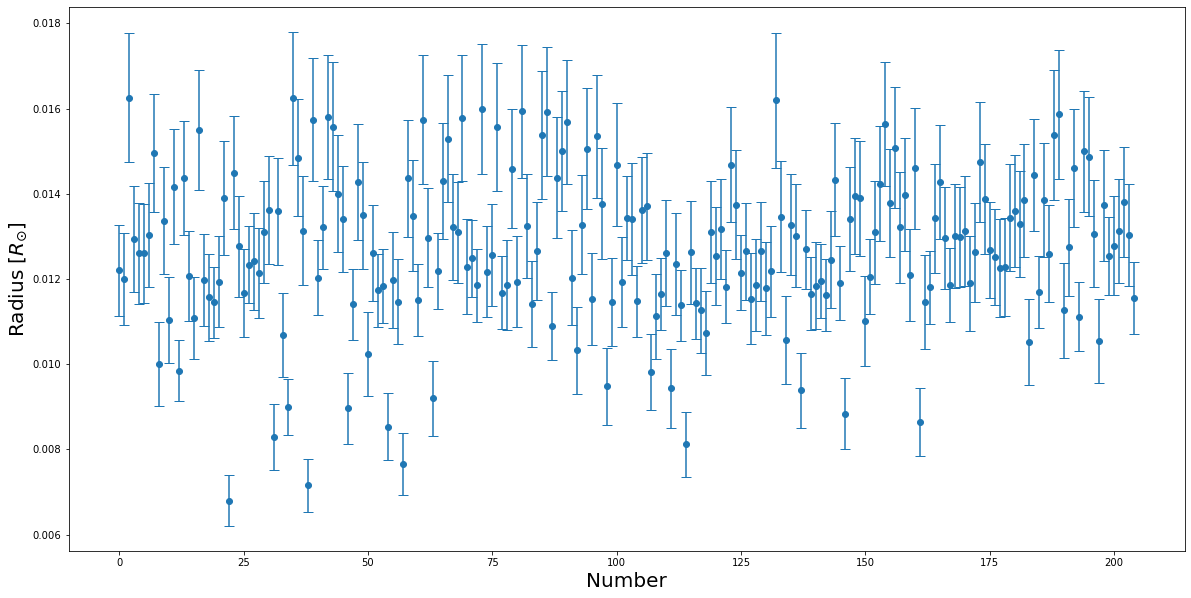

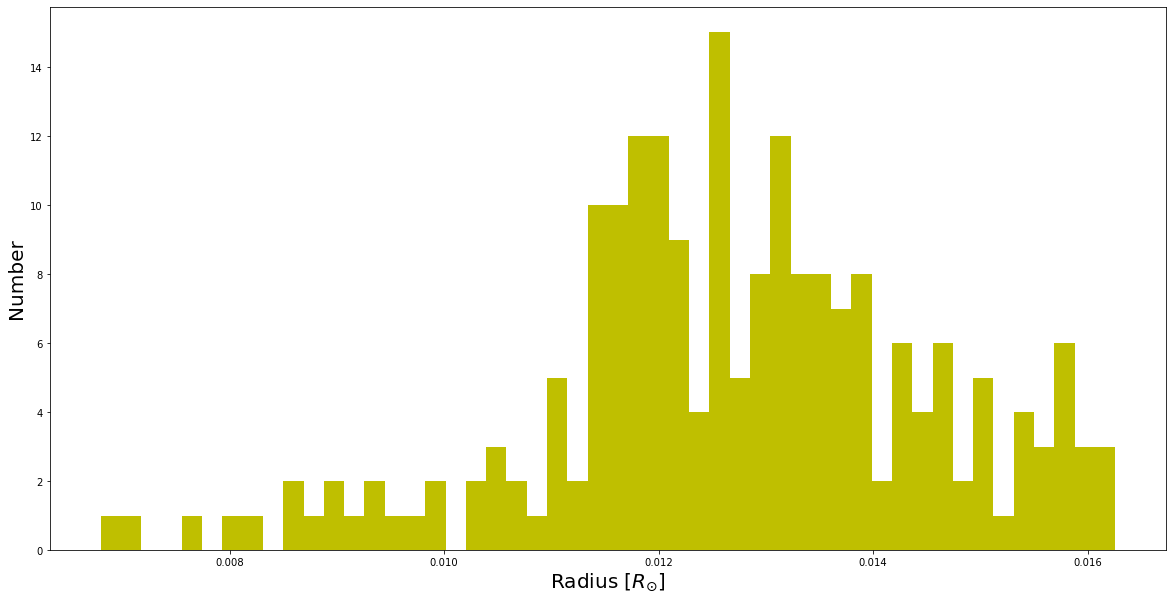

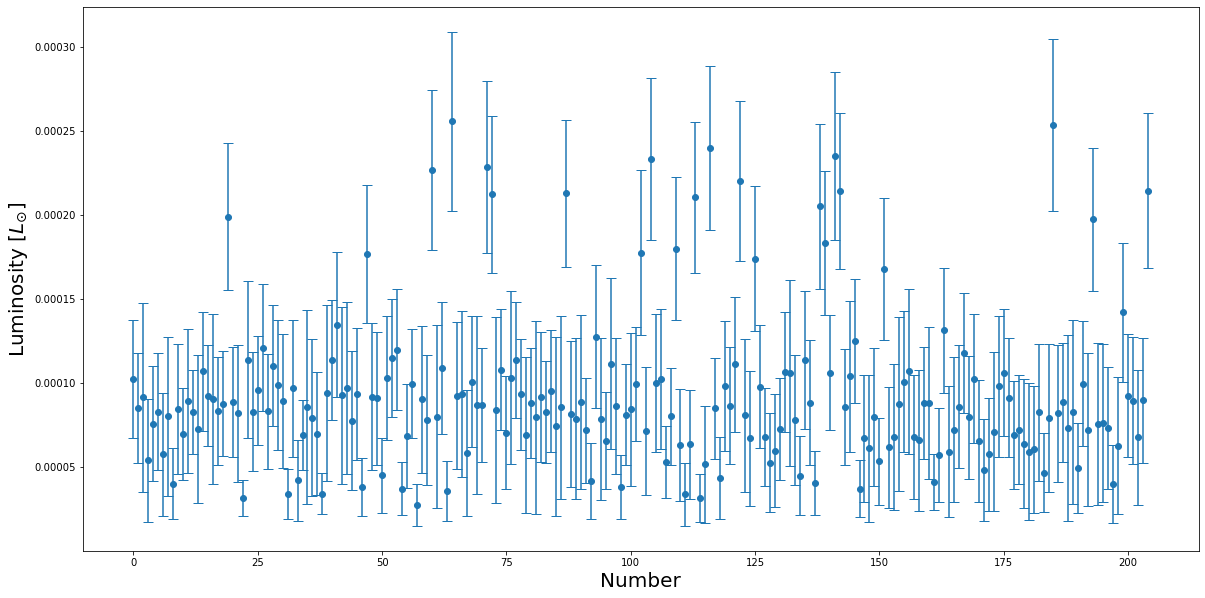

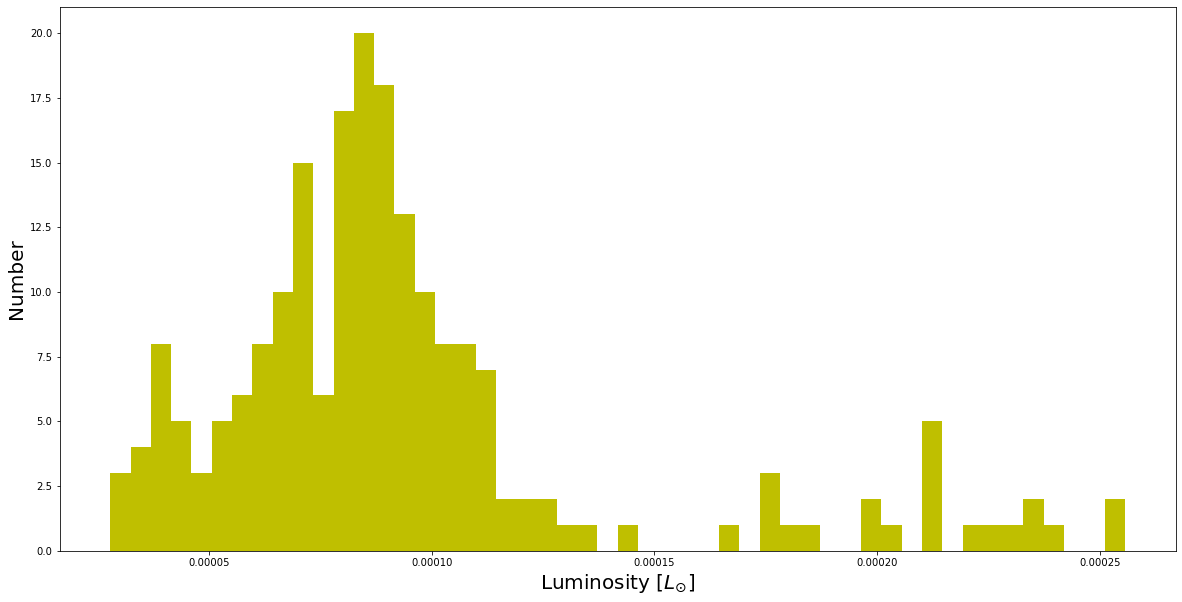

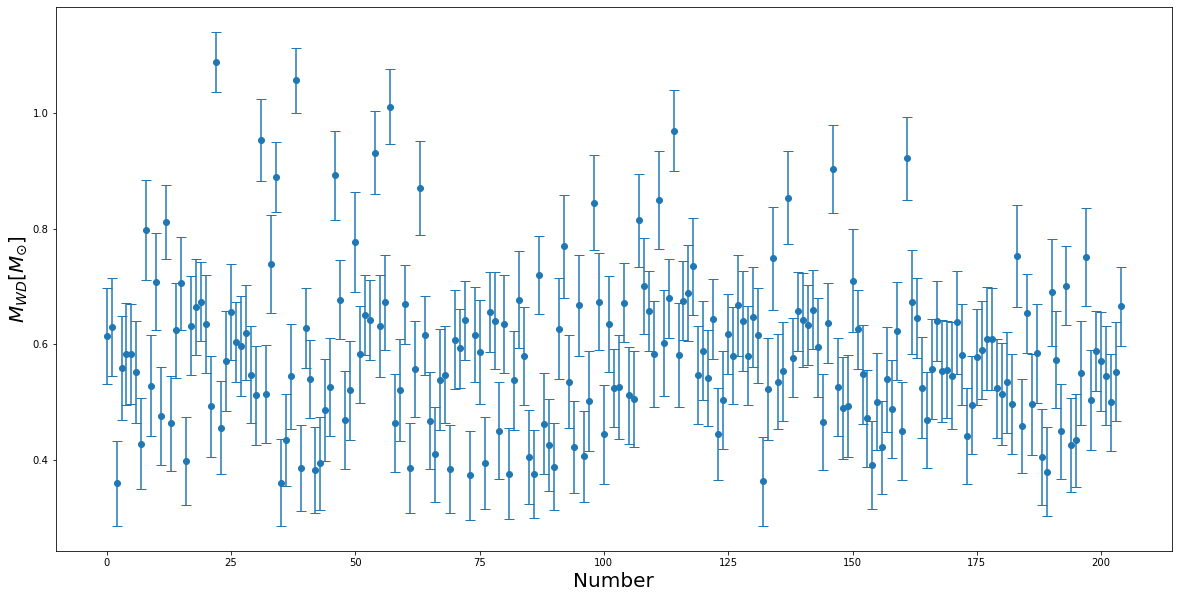

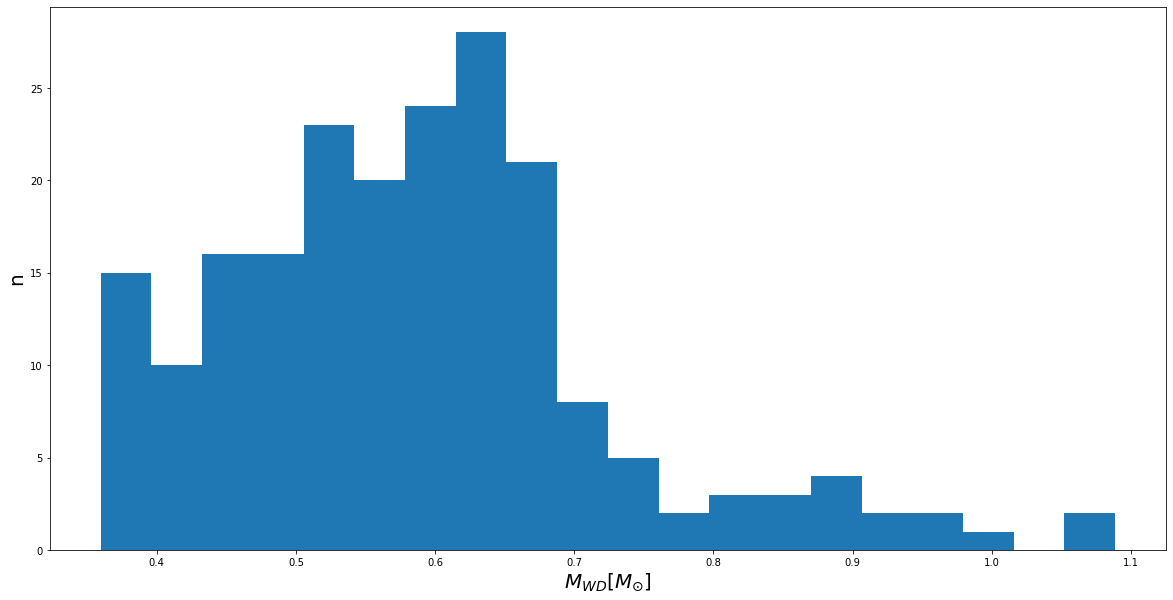

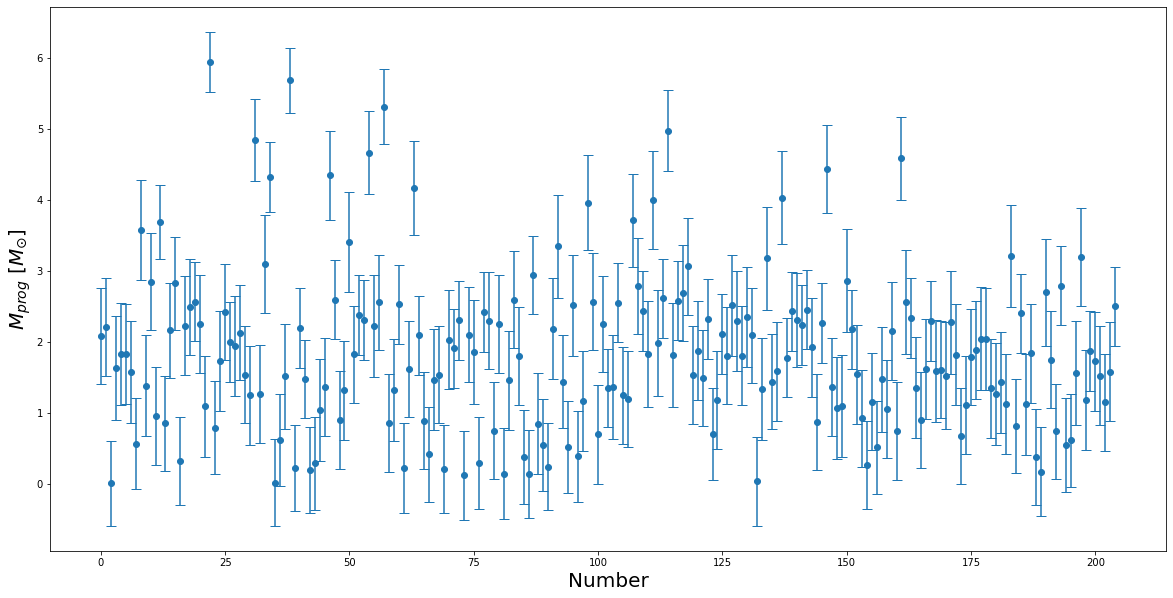

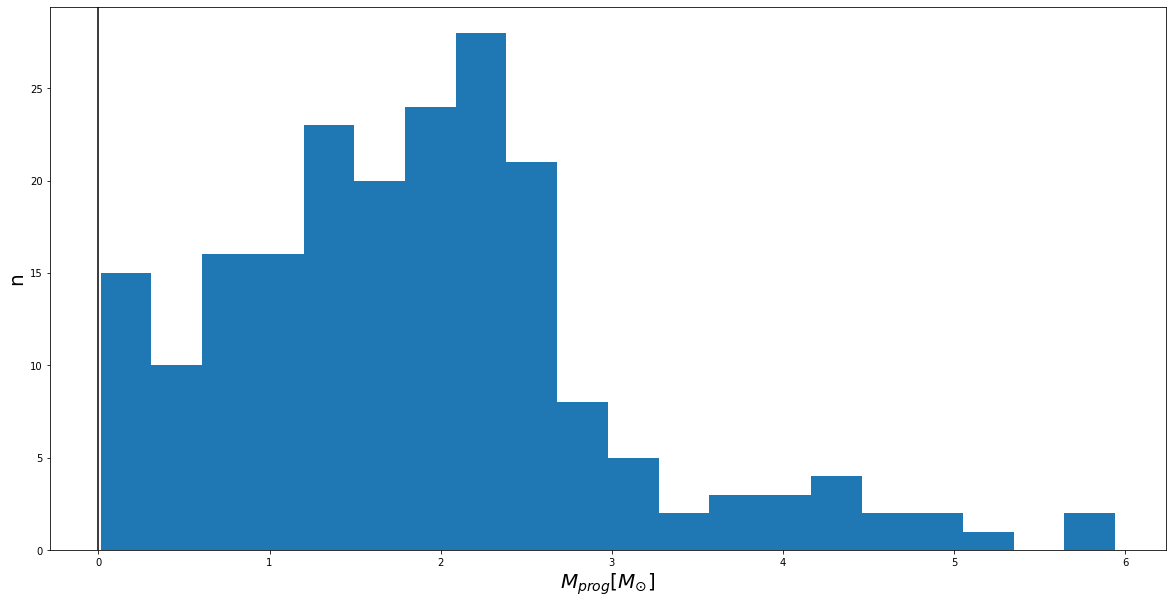

Percentage of analyzed WDs =  82.32931726907631 % Total number:  205
         
T_median =  4814.360432333215  +-  304.53564964353245  K
T_mean =  4982.655066691309  +-  593.6058505945978  K
         
L_median =  8.542394211439537e-05  +-  1.7086562189012525e-05  L_sun
L_mean =  9.416893397291486e-05  +-  4.6321790755763704e-05  L_sun
         
R_median =  0.01264732557656926  +-  0.0010815407023760173  R_Sun
R_mean =  0.012694724676003423  +-  0.0018238108423447971  R_Sun
         
M_median =  0.580299754984413  +-  0.07729336209170357  M_Sun
R_mean =  0.5874552543041158  +-  0.1376020144860727  M_Sun
         
Number of CO-WDs:  90.2439024390244 % Total number:  185
Number of He-WDs:  9.75609756097561 % Total number:  20
Number of NeMg-WDs:  0.0 % Total number:  0
Number of neglected objects:  0.0 % Total number:  0


In [3]:
Temp = []
Lum = []
Radii = []
colors = []
masses = []
mag = []
Mprog_mean = []

# CONSTANTS DEFINITIONS

T_sun = 5777 # K
SB , h = 5.67e-8 , 6.63e-34
M_sun = 1.989e30 # kg
R_sun = 6.95508e8 # m
L_sun = 3.828e26 # W

a , c = 0.0126 , (1.435**(2/3)) # constants for mass calculation
d , o = c/a , (2*c)**2

co = 0
he = 0
nemg = 0

counter = 0

for i in range( len(c_VI) ):
    
    color = c_VI[i]  
    mi = m_i[i] 
    cp , cm = unumpy.nominal_values(color)+unumpy.std_devs(color) , unumpy.nominal_values(color)-unumpy.std_devs(color)
    
    if cm > 0.4 and cp < 1.55:
        
        Te = ufloat(9058.78 , 166.72) - ufloat(6152.43 , 403.46)*color + ufloat(1987.84 , 217.38)*color*color
    
        R = 10**(7 + ((11.363 + dist_modul_0 + 2.77*color - mi)/5)) # Hansen et al. , 2007

        L = 4*np.pi*SB*(Te**4)*(R)**2

        b = (d**2)*(R/R_sun)**2
        M = ( ( ( b**2 + o )**(0.5) - b )/2 )**(3/2)
        
        if M > 0.358:
            
            M_prog = (M-0.358)/0.123
            
            Mp_m = unumpy.nominal_values(M_prog)
            
            if Mp_m >= 0.5 and Mp_m <= 8:
                co += 1
            elif Mp_m < 0.5:
                he += 1
            elif Mp_m > 8:
                nemg += 1
            else:
                counter += 1
                
            Mprog_mean.append(M_prog)
            masses.append(M)
            Temp.append(Te)
            Lum.append(L/L_sun)
            Radii.append(R/R_sun)
            colors.append(color)
            mag.append(mi)

#############################################

plt.figure(figsize = [20,10])
plt.errorbar(x = unumpy.nominal_values(colors) , y = unumpy.nominal_values(mag) , 
            xerr = unumpy.std_devs(colors) , yerr = unumpy.std_devs(mag) , 
             fmt = '.' , capsize = 5 , color = 'r')
plt.plot(unumpy.nominal_values(colors) , unumpy.nominal_values(mag) , 'bo' , markersize = 5)
plt.xlabel('V-I' , fontsize = 20)
plt.ylabel('$m_{I}$' , fontsize = 20)
plt.gca().invert_yaxis()
plt.show()

#############################################

plt.figure(figsize = [20,10])
plt.errorbar(np.arange(len(Temp)), unumpy.nominal_values(Temp), yerr=unumpy.std_devs(Temp) ,  fmt = 'o' , capsize = 5)
plt.xlabel('Number' , fontsize = 20)
plt.ylabel('Temperature [K]' , fontsize = 20)
plt.savefig('T_WD.png')
plt.show()

plt.figure(figsize = [20,10])
plt.hist(unumpy.nominal_values(Temp) , bins = 50 , color = 'y')
plt.xlabel('Temperature [K]' , fontsize = 20)
plt.ylabel('n' , fontsize = 20)
plt.savefig('T_WD_hist.png')
plt.show()

###############################################

plt.figure(figsize = [20,10])
plt.errorbar(np.arange(len(Temp)), unumpy.nominal_values(Radii), yerr=unumpy.std_devs(Radii) ,  fmt = 'o' , capsize = 5)
plt.xlabel('Number' , fontsize = 20)
plt.ylabel('Radius [$R_{\odot}$]' , fontsize = 20)
plt.savefig('R_WD.png')
plt.show()

plt.figure(figsize = [20,10])
plt.hist(unumpy.nominal_values(Radii) , bins = 50 , color = 'y')
plt.xlabel('Radius [$R_{\odot}$]' , fontsize = 20)
plt.ylabel('Number' , fontsize = 20)
plt.savefig('R_WD_hist.png')
plt.show()

###############################################

plt.figure(figsize = [20,10])
plt.errorbar(np.arange(len(Temp)), unumpy.nominal_values(Lum), yerr=unumpy.std_devs(Lum) ,  fmt = 'o' , capsize = 5)
plt.xlabel('Number' , fontsize = 20)
plt.ylabel('Luminosity [$L_{\odot}$]' , fontsize = 20)
plt.savefig('L_WD.png')
plt.show()

plt.figure(figsize = [20,10])
plt.hist(unumpy.nominal_values(Lum) , bins = 50 , color = 'y')
plt.xlabel('Luminosity [$L_{\odot}$]' , fontsize = 20)
plt.ylabel('Number' , fontsize = 20)
plt.savefig('L_WD_hist.png')
plt.show()

###############################################

plt.figure(figsize = [20,10])
plt.errorbar( np.arange(len(masses)) , unumpy.nominal_values(masses) , yerr = unumpy.std_devs(masses) , fmt = 'o' , capsize = 5)
plt.xlabel('Number' , fontsize = 20)
plt.ylabel('$M_{WD} [M_{\odot}]$' , fontsize = 20)
plt.savefig('M_WD.png')
plt.show()

plt.figure(figsize = [20 , 10])
plt.hist(unumpy.nominal_values(masses) , bins = 20)
plt.xlabel('$M_{WD} [M_{\odot}]$' , fontsize = 20)
plt.ylabel('n' , fontsize = 20)
plt.savefig('M_WD_hist.png')
plt.show()

###############################################

plt.figure(figsize = [20,10])
plt.errorbar(np.arange(len(Mprog_mean)), unumpy.nominal_values(Mprog_mean), yerr=unumpy.std_devs(Mprog_mean) ,  fmt = 'o' , capsize = 5)
plt.xlabel('Number' , fontsize = 20)
plt.ylabel('$M_{prog}$ [$M_{\odot}$]' , fontsize = 20)
plt.savefig('M_prog.png')
plt.show()

plt.figure(figsize = [20 , 10])
plt.hist(unumpy.nominal_values(Mprog_mean) , bins = 20)
plt.xlabel('$M_{prog} [M_{\odot}]$' , fontsize = 20)
plt.ylabel('n' , fontsize = 20)
plt.axvline(0 , color = 'k')
plt.savefig('M_prog_hist.png')
plt.show()

###############################################

print( "Percentage of analyzed WDs = " , (len(Temp)/len(C_WD))*100 , '%' , "Total number: " , len(Temp) )
print( "         " )
print( "T_median = " , np.median(unumpy.nominal_values(Temp)) , ' +- ' , MAD(unumpy.nominal_values(Temp)) , ' K' )
print( "T_mean = " , np.mean(unumpy.nominal_values(Temp)) , ' +- ' , np.std(unumpy.nominal_values(Temp)) , ' K' )
print( "         " )
print( "L_median = " , np.median(unumpy.nominal_values(Lum)) , ' +- ' , MAD(unumpy.nominal_values(Lum)) , ' L_sun' )
print( "L_mean = " , np.mean(unumpy.nominal_values(Lum)) , ' +- ' , np.std(unumpy.nominal_values(Lum)) , ' L_sun' )
print( "         " )
print( "R_median = " , np.median(unumpy.nominal_values(Radii)) , ' +- ' , MAD(unumpy.nominal_values(Radii)) , ' R_Sun' )
print( "R_mean = " , np.mean(unumpy.nominal_values(Radii)) , ' +- ' , np.std(unumpy.nominal_values(Radii)) , ' R_Sun' )
print( "         " )
print( "M_median = " , np.median(unumpy.nominal_values(masses)) , ' +- ' , MAD(unumpy.nominal_values(masses)) , ' M_Sun' )
print( "R_mean = " , np.mean(unumpy.nominal_values(masses)) , ' +- ' , np.std(unumpy.nominal_values(masses)) , ' M_Sun' )
print( "         " )
print("Number of CO-WDs: " , (co/len(Radii))*100 , '%' , "Total number: " , co)
print("Number of He-WDs: " , (he/len(Radii))*100 , '%' , "Total number: " , he)
print("Number of NeMg-WDs: " , (nemg/len(Radii))*100 , '%' , "Total number: " , nemg)
print("Number of neglected objects: " , (counter/len(Radii))*100 , '%' , "Total number: " , counter)

# Parte 4: Età di raffreddamento

Il tempo di raffrreddamento è ottenuto dalla legge di Mestel, con coefficienti forniti dalla tesi di (Aricò, 2014):

$$ t_{cool} = 0.0088\frac{12}{A}\left(\frac{2}{\mu}\right)^{\frac{2}{7}}\left(\frac{M}{L}\right)^{\frac{5}{7}} $$

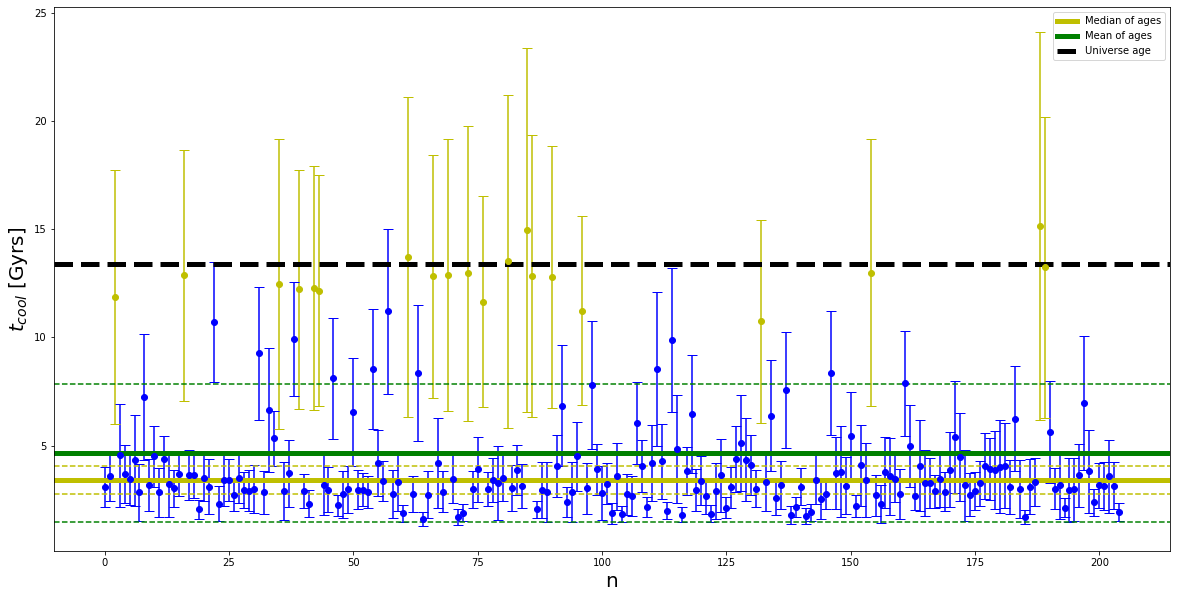

Median of T-COOL =  3.398556464789537 +- 0.6520997899594247 Gyrs
Mean of T-COOL =  4.651528415025385 +- 3.181845886111021 Gyrs


In [4]:
plt.figure(figsize = [20,10])

TIMES = []

HeWD , COWD , NeMgWD = [] , [] , []

kost = 0

for i in range( len(Mprog_mean) ):

    if unumpy.nominal_values(Mprog_mean[i]) < 0.5 and unumpy.nominal_values(Mprog_mean[i]) > 0:
        
        A , Aenv = 4 , 1
        
        t = Mestel( A , Aenv , masses[i] , Lum[i] , Temp[i] , Radii[i])
        t0 = unumpy.nominal_values(t)
        dt = unumpy.std_devs(t)
        
        TIMES.append(t0)
        plt.errorbar( i , t0 , yerr = dt , fmt = 'o' , capsize = 5 , color = 'y' )
        HeWD.append(t)
        kost += 1
        
    elif unumpy.nominal_values(Mprog_mean[i]) >= 0.5 and unumpy.nominal_values(Mprog_mean[i]) <= 8:
        
        A , Aenv = 14 , 4
        
        t = Mestel( A , Aenv , masses[i] , Lum[i] , Temp[i] , Radii[i])
        t0 = unumpy.nominal_values(t)
        dt = unumpy.std_devs(t)
        
        TIMES.append(t0)
        plt.errorbar( i , t0 , yerr = dt , fmt = 'o' , capsize = 5 , color = 'b')
        COWD.append(t)
        kost += 1
        
    elif unumpy.nominal_values(Mprog_mean[i]) > 8 and unumpy.nominal_values(Mprog_mean[i]) < 10:
        
        A , Aenv = 22 , 12
        
        t = Mestel( A , Aenv , masses[i] , Lum[i] , Temp[i] , Radii[i])
        t0 = unumpy.nominal_values(t)
        dt = unumpy.std_devs(t)
        
        TIMES.append(t0)
        plt.errorbar( i , t0 , yerr = dt , fmt = 'o' , capsize = 5 , color = 'r' )
        NeMgWD.append(t)
        kost += 1

plt.savefig('t_cool.png')

plt.axhline( np.median(TIMES) , color = 'y' , label = 'Median of ages', linewidth = 5 )
plt.axhline( np.median(TIMES) + MAD(TIMES) , color = 'y' , linestyle = '--' )
plt.axhline( np.median(TIMES) - MAD(TIMES) , color = 'y' , linestyle = '--' )

plt.axhline( np.mean(TIMES) , color = 'g' , label = 'Mean of ages' , linewidth = 5)
plt.axhline( np.mean(TIMES) + np.std(TIMES) , color = 'g' , linestyle = '--' )
plt.axhline( np.mean(TIMES) - np.std(TIMES) , color = 'g' , linestyle = '--' )

plt.axhline(13.4 , color = 'k' , label = 'Universe age' , linewidth = 5 , linestyle = '--')

plt.ylabel('$t_{cool}$ [Gyrs]' , fontsize = 20)
plt.xlabel('n' , fontsize = 20)
plt.legend()
plt.savefig('t_cool2.png')
plt.show()

print("Median of T-COOL = " , np.median(TIMES) , '+-' , MAD(TIMES) , 'Gyrs')
print("Mean of T-COOL = " , np.mean(TIMES) , '+-' , np.std(TIMES) , 'Gyrs')

# Parte 5: Stima dell'età dell'ammasso

Per trovare l'età totale di ogni singola nana bianca, sommiamo al tempo di raffreddamento il tempo passato sulla Main Sequence, stimato usando al seguente relazione (Iben and Tutukov, 1987):

$$ t_{MS} = \frac{10}{M_{prog}^{\frac{5}{2}}} $$

Dopo aver fatto questo, si ottengono dei valori le cui barre d'errore superano il livello 0 (i.e. il presente), che non rappresentiamo in un grafico dato il livello di confusione dello stesso.

Si è scelto quindi di procedere fissando, a intervalli dati, dei valori limite oltre i quali ogni stella con barra d'errore più grande dei suddetti, non viene più calcolata (per esempio, se una stella ha una barra d'errore tale che $ |t + \Delta t| \geq lim $, essa non sarà calcolata nel calcolo finale dell'età media e mediana.

Detto questo, per ogni loop in cui al valore limite viene aggiungo un valore costante (chiamato $\textit{res}$), vengono calcolate le età dei progenitori, separandoli in progenitori per He-Wd , CO-WD e NeMg-Wd, e inoltre si calcola l'età mediana della popolazione rimanente dopo l'applicazione del valore limite.

Si vede subito che non si ha nessuna nana bianca al NeMg e, inoltre, si vede che per qualunque valore limite scelto nessuna nana bianca all' He viene mantenuta all'interno del conteggio finale.

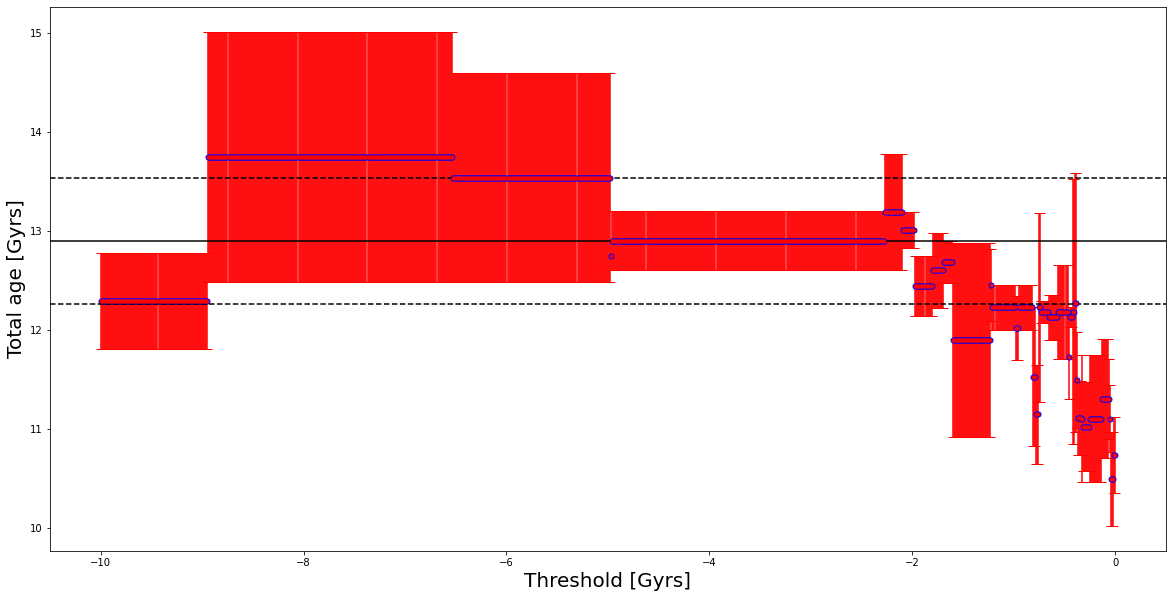

12.903394080628427 +- 0.635890917112464


In [9]:
AGES = []
sigmaAGES = []
thresholds = []
res = 0.01
for lim in np.arange(-10 , 0+res , res):

    T_prog = []
    prog_CO = []
    prog_He = []
    prog_NeMg = []
    THe , TCO , TNeMg = [] , [] , []

    mag2 , color2 = [] , []

    outliersHe = 0
    outliersCO = 0
    outliersNeMg = 0

    for i in range(len(Mprog_mean)):

        m = Mprog_mean[i]

        T = ageprog(m) + 

        col2 = colors[i]
        mm2 = mag[i]

        if unumpy.nominal_values(m) < 0.5 and unumpy.nominal_values(m) > 0:

            if unumpy.nominal_values(T) - unumpy.std_devs(T) > lim:
                T_prog.append(T)
                prog_He.append(Mprog_mean[i])
                THe.append(T)
                mag2.append(mm2)
                color2.append(col2)
            else:
                outliersHe += 1

        elif unumpy.nominal_values(m) >= 0.5 and unumpy.nominal_values(m) < 8:

            if unumpy.nominal_values(T) - unumpy.std_devs(T) > lim:
                T_prog.append(T)
                prog_CO.append(Mprog_mean[i])
                TCO.append(T)
                mag2.append(mm2)
                color2.append(col2)
            else:
                outliersCO += 1

        elif unumpy.nominal_values(m) >= 8:

            if unumpy.nominal_values(T) - unumpy.std_devs(T) > lim:
                T_prog.append(T)
                prog_NeMg.append(Mprog_mean[i])
                TNeMg.append(T)
                mag2.append(mm2)
                color2.append(col2)
            else:
                outliersNeMg += 1

    Tpm = unumpy.nominal_values(T_prog)        

    #############################################

    #print("The total number of probable He-WD outliers is: ", outliersHe , 1/(len(HeWD)/outliersHe)*100 , '%')
    #print("The total number of probable CO-WD outliers is: ", outliersCO , 1/(len(COWD)/outliersCO)*100 , '%')
    #print("The total number of probable NeMg-WD outliers is: ", outliersNeMg , 1/(len(HeWD)/outliersHe)*100 , '%')
    #print("The total number of time-included WD is: " , len(T_prog) , 100*len(T_prog)/len(masses) , "%")

    ###################################################################

    T_tot = []
    err_Count = 0

    if len(TNeMg) > -1:
        for i in range(len(TNeMg)):
            t = NeMgWD[i] + TNeMg[i]
            T_tot.append(t)
            if T_tot[i] > 13.4:
                err_Count += 1

    if len(THe) > -1:
        for i in range(len(THe)):
            t = HeWD[i] + THe[i]
            T_tot.append(t)
            if T_tot[i] > 13.4:
                err_Count += 1

    for i in range(len(TCO)):
        t = COWD[i] + TCO[i]
        T_tot.append(t)
        if T_tot[i] > 13.4:
            err_Count += 1  

    Tt = unumpy.nominal_values(T_tot)
    Ttstd = unumpy.std_devs(T_tot)
    
    #print('Total mean age WDs: ' , np.mean(Tt) , '+-' , np.std(Tt) , 'Gyrs')

    ###################################################################

    old_mean = []
    old_std = []
    for i in range(len(Tt)):
        if Tt[i]-Ttstd[i] > np.mean(Tt)+np.std(Tt):
            old_mean.append(Tt[i])
            old_std.append(Ttstd[i])

    #print('Oldest median age: ' , np.median(old_mean) , '+-' , MAD(old_mean) , 'Gyrs')
    
    if math.isnan(np.median(old_mean)):
        continue
    else:
        AGES.append(np.median(old_mean))
        sigmaAGES.append(MAD(old_mean))
        thresholds.append(lim)
        
plt.figure(figsize = [20,10])
plt.errorbar(x = thresholds , y = AGES , yerr = sigmaAGES , fmt = '.' , capsize = 5 , color = 'r')
plt.plot(thresholds , AGES , 'bo' , markersize = 5)

plt.axhline(np.median(AGES) , color = 'k')
plt.axhline(np.median(AGES) + MAD(AGES) , color = 'k' , linestyle = '--')
plt.axhline(np.median(AGES) - MAD(AGES) , color = 'k' , linestyle = '--')

plt.ylabel('Total age [Gyrs]' , fontsize = 20)
plt.xlabel('Threshold [Gyrs]' , fontsize = 20)
plt.show()

print(np.median(AGES), '+-' ,MAD(AGES))

# Parte 5: Stima dell'età dell'ammasso ( Bootstrap )

Per trovare l'età totale di ogni singola nana bianca, sommiamo al tempo di raffreddamento il tempo passato sulla Main Sequence, stimato usando al seguente relazione (Iben and Tutukov, 1987):

$$ t_{MS} = \frac{10}{M_{prog}^{\frac{5}{2}}} $$

102


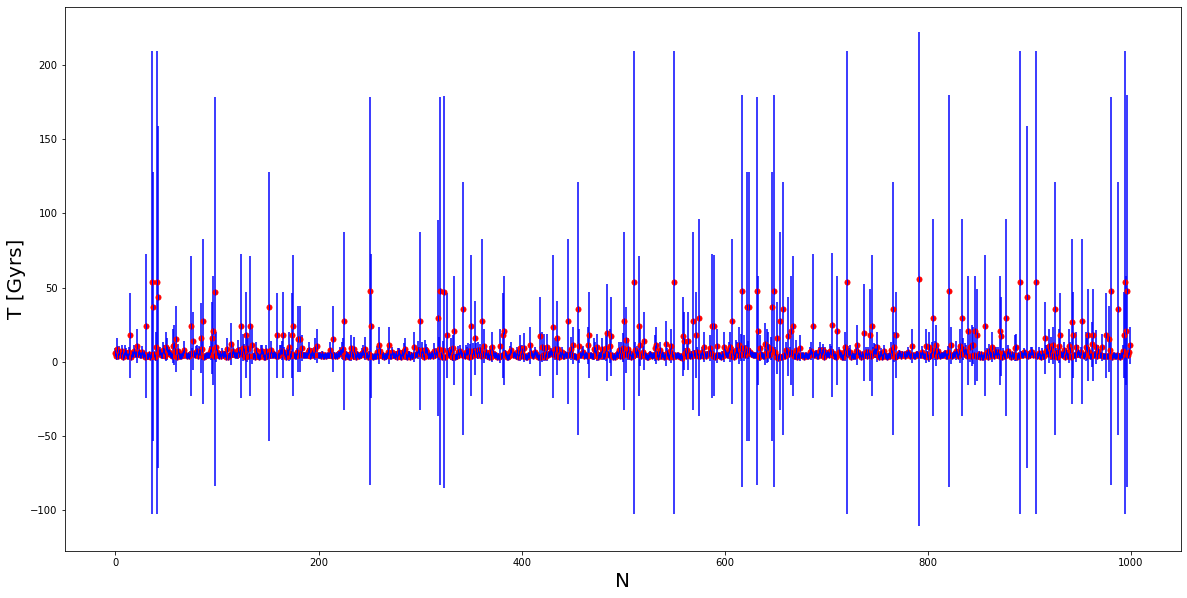

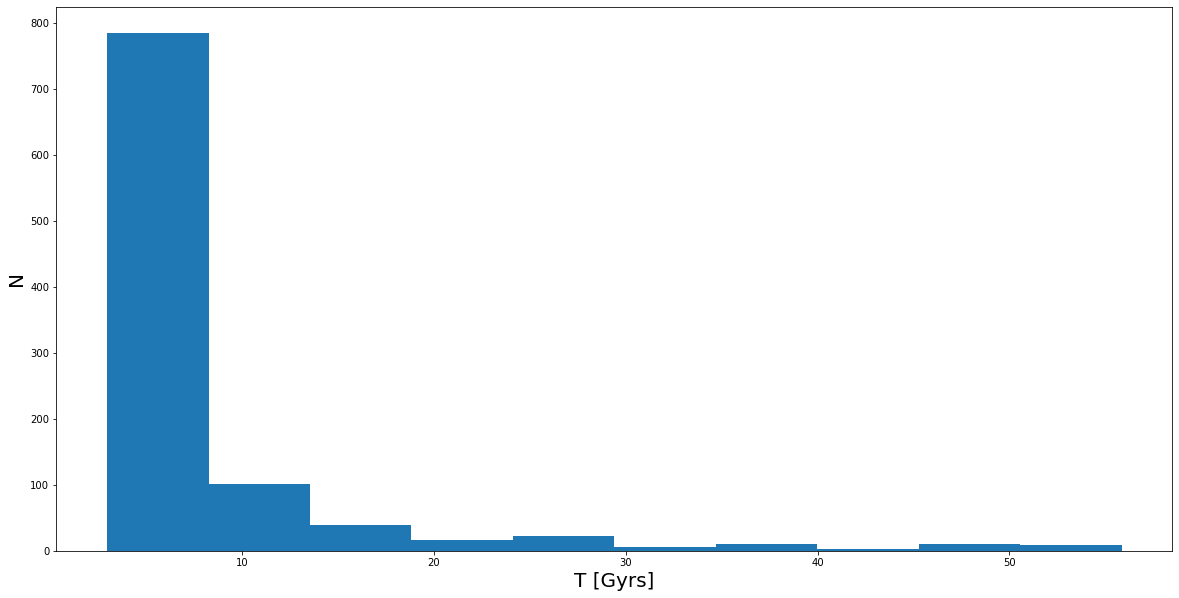

5.3027552356392835 +- 1.3231066580452544
8.177694286037545 +- 26.990043480240526


In [155]:
num_samples = int( len(Mprog_mean)/2  )

print(num_samples)

times = []

for n in range(1000):

    T_prog = []
    prog_CO = []
    prog_He = []
    prog_NeMg = []
    THe , TCO , TNeMg = [] , [] , []

    mag2 , color2 = [] , []
    
    ARRAY = np.random.choice(Mprog_mean , num_samples)
    
    tt = np.zeros(len(ARRAY))

    for i in range(len(ARRAY)):

        if unumpy.nominal_values(ARRAY[i]) < 0.5 and unumpy.nominal_values(ARRAY[i]) > 0:
            A , Aenv = 4 , 1
            
            continue
            
        elif unumpy.nominal_values(ARRAY[i]) >= 0.5 and unumpy.nominal_values(ARRAY[i]) <= 8:
            A , Aenv = 14 , 4
            
            T = ageprog(ARRAY[i]) + Mestel( A , Aenv , masses[i] , Lum[i] , Temp[i] , Radii[i])
        
            tt[i] = unumpy.nominal_values(T)
            
        elif unumpy.nominal_values(ARRAY[i]) > 8 and unumpy.nominal_values(ARRAY[i]) < 10:
            A , Aenv = 22 , 12
            
            T = ageprog(ARRAY[i]) + Mestel( A , Aenv , masses[i] , Lum[i] , Temp[i] , Radii[i])
        
            tt[i] = unumpy.nominal_values(T)

    
    times.append(np.mean(T))
    
plt.figure(figsize = [20,10])

plt.errorbar(np.arange(len(times)) , unumpy.nominal_values(times) , yerr = unumpy.std_devs(times) , color = 'b' , fmt = '|')
plt.plot(unumpy.nominal_values(times) , 'ro' , markersize = 5)

plt.ylabel('T [Gyrs]' , fontsize = 20)
plt.xlabel('N' , fontsize = 20)

plt.show()

#######################################################

plt.figure(figsize = [20,10])

plt.hist(unumpy.nominal_values(times) , bins = 10)

plt.xlabel('T [Gyrs]' , fontsize = 20)
plt.ylabel('N' , fontsize = 20)
plt.show()

print(np.median(unumpy.nominal_values(times)) , '+-' , MAD(unumpy.nominal_values(times)) )
print(np.mean(unumpy.nominal_values(times)) , '+-' , np.sqrt(np.std(unumpy.nominal_values(times))**2 + np.mean(unumpy.std_devs(times)**2)) )
# , '+-' , np.sqrt(np.std(unumpy.nominal_values(times))**2 + np.mean(unumpy.std_devs(times)**2)) , 'Gyrs')



# Appendice : cosa ottengo da ogni loop

Fissando il valore limite vedo che riesco a vedere meglio il grafico con i singoli tempi di Main Sequence di ogni progenitore, inoltre, vedendo sul CMD dove si trovano i singoli oggetti che vengono scartati, rimangono tutti in una zona che potrebbe indicare la presenza di particoalri binarie oppure nane bianche "spurie" (Falsi Positivi).

L'ultimo grafico corrisponde a un'ulteriore cesura del dataset, fatta prendendo come valore limite il valore massimo della media delle età delle rimanenti WDs, e prendendo in considerazione soltanto le WDs che si dispongono totalmente sopra quel massimo. Si può notare che se si seleziona un valore limite maggiore doi -10 Gyrs, nessuna WD avalla questa ulteriore cesura.

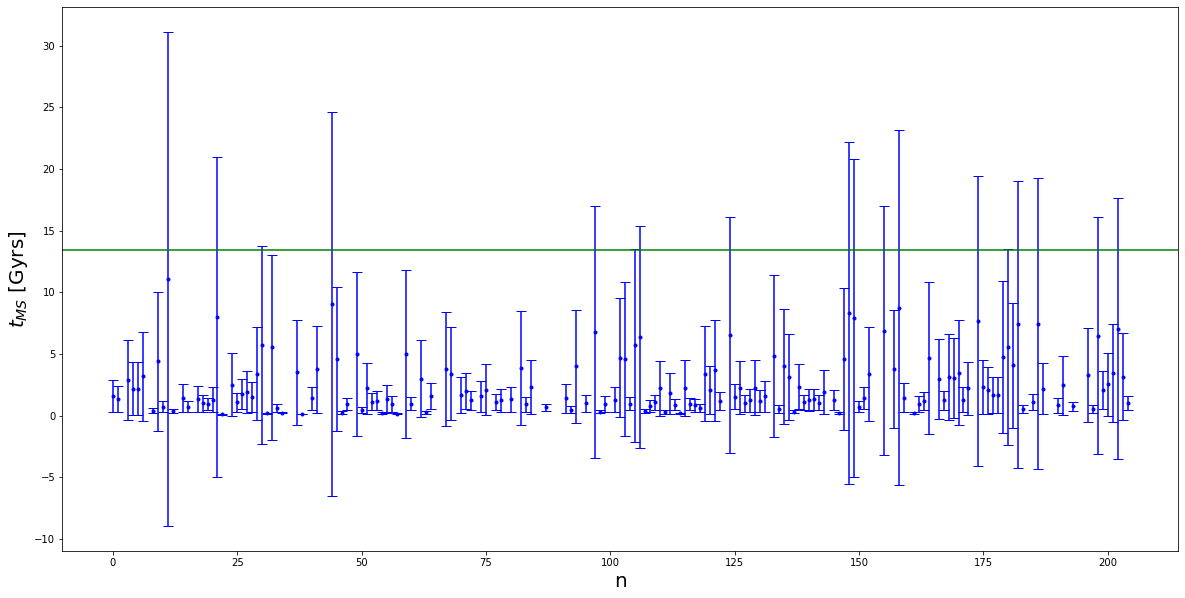

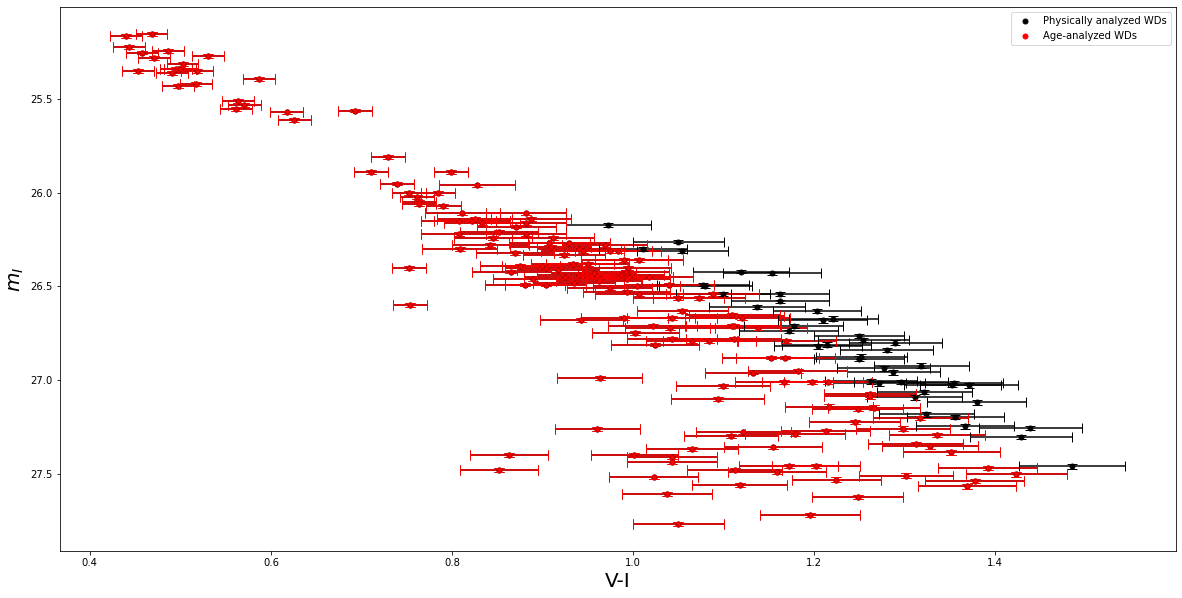

The total number of probable He-WD outliers is:  20 100.0 %
The total number of probable CO-WD outliers is:  23 12.432432432432433 %
The total number of probable NeMg-WD outliers is:  0 100.0 %
The total number of time-included WD is:  162 79.02439024390245 %
Median of T-PROGENITOR =  1.5880228444203859 +- 0.8707441944950165 Gyrs
Mean of T-PROGENITOR =  2.472410351727021 +- 2.181481212154291 Gyrs
Oldest progenitor:  11.078845193345956 Gyrs
Number of CO-WDs with age > 13.4 Gyrs:  3.0864197530864197 %


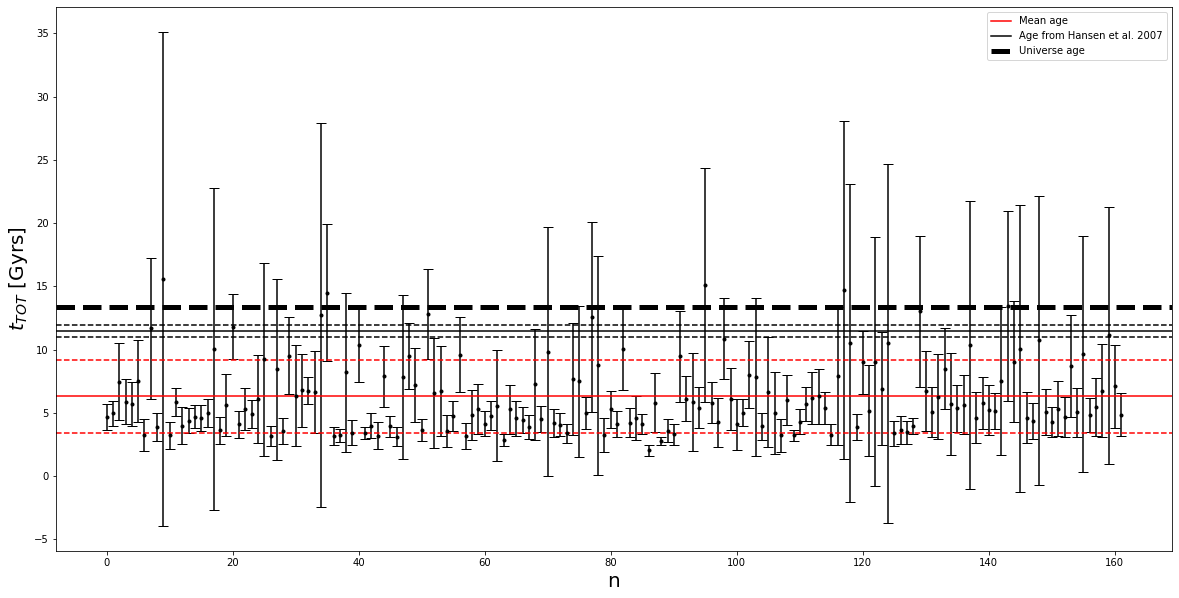

Total median age WDs:  5.365828599172006 +- 1.439616074119195 Gyrs
Total mean age WDs:  6.287874017703016 +- 2.8611163201868104 Gyrs


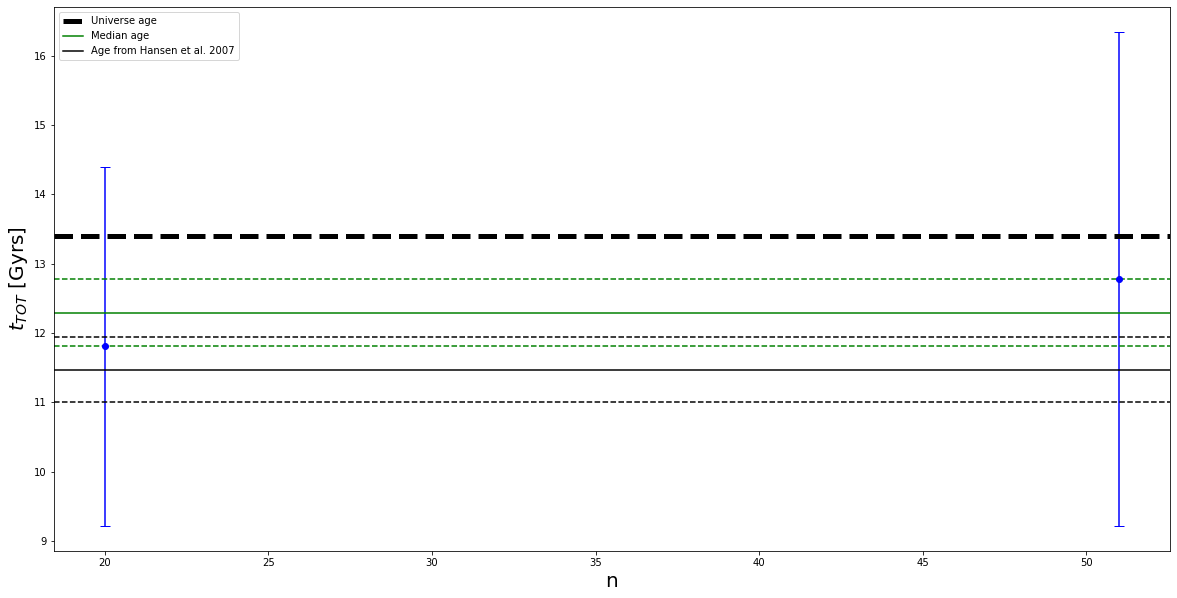

Oldest mean age:  12.294170275710677 +- 0.485907205226467 Gyrs
Oldest median age:  12.294170275710677 +- 0.485907205226467 Gyrs


In [163]:


lim = -10


T_prog = []
prog_CO = []
prog_He = []
prog_NeMg = []
THe , TCO , TNeMg = [] , [] , []

mag2 , color2 = [] , []

outliersHe = 0
outliersCO = 0
outliersNeMg = 0

plt.figure(figsize = [20,10])
for i in range(len(Mprog_mean)):
    
    m = Mprog_mean[i]
    
    T = ageprog(m)
    
    col2 = colors[i]
    mm2 = mag[i]
    
    if unumpy.nominal_values(m) < 0.5 and unumpy.nominal_values(m) > 0:
        
        if unumpy.nominal_values(T) - unumpy.std_devs(T) > lim:
            T_prog.append(T)
            prog_He.append(Mprog_mean[i])
            plt.errorbar(i , unumpy.nominal_values(T), yerr = unumpy.std_devs(T) , fmt = '.' , capsize = 5 , color= 'y') ### I do not count the He-WD because they do not have yet formed from aging
            THe.append(T)
            mag2.append(mm2)
            color2.append(col2)
        else:
            outliersHe += 1
        
    elif unumpy.nominal_values(m) >= 0.5 and unumpy.nominal_values(m) < 8:
        
        if unumpy.nominal_values(T) - unumpy.std_devs(T) > lim:
            T_prog.append(T)
            prog_CO.append(Mprog_mean[i])
            TCO.append(T)
            plt.errorbar(i , unumpy.nominal_values(T), yerr = unumpy.std_devs(T) , fmt = '.' , capsize = 5 , color= 'b')
            mag2.append(mm2)
            color2.append(col2)
        else:
            outliersCO += 1
            
    elif unumpy.nominal_values(m) >= 8:
        
        if unumpy.nominal_values(T) - unumpy.std_devs(T) > lim:
            T_prog.append(T)
            prog_NeMg.append(Mprog_mean[i])
            TNeMg.append(T)
            plt.errorbar(i , unumpy.nominal_values(T), yerr = unumpy.std_devs(T) , fmt = '.' , capsize = 5 , color= 'r')
            mag2.append(mm2)
            color2.append(col2)
        else:
            outliersNeMg += 1
            
Tpm = unumpy.nominal_values(T_prog)        

plt.xlabel('n' , fontsize = 20)
plt.ylabel('$t_{MS}$ [Gyrs]' , fontsize = 20)
plt.axhline(13.4 , color = 'g')
#plt.savefig('t_prog1.png')
plt.show()

#############################################

plt.figure(figsize = [20,10])

plt.errorbar(x = unumpy.nominal_values(colors) , y = unumpy.nominal_values(mag) , 
            xerr = unumpy.std_devs(colors) , yerr = unumpy.std_devs(mag) , 
            fmt = '.' , capsize = 5 , color = 'k')
plt.plot(unumpy.nominal_values(colors) , unumpy.nominal_values(mag) , 'ko' , markersize = 5 , label = 'Physically analyzed WDs')

plt.errorbar(x = unumpy.nominal_values(color2) , y = unumpy.nominal_values(mag2) , 
            xerr = unumpy.std_devs(color2) , yerr = unumpy.std_devs(mag2) , 
            fmt = '.' , capsize = 5 , color = 'r')
plt.plot(unumpy.nominal_values(color2) , unumpy.nominal_values(mag2) , 'ro' , markersize = 5 , label = 'Age-analyzed WDs')

plt.xlabel('V-I' , fontsize = 20)
plt.ylabel('$m_{I}$' , fontsize = 20)
plt.gca().invert_yaxis()
plt.legend()
#plt.savefig('newCMD1.png')
plt.show()

#############################################

print("The total number of probable He-WD outliers is: ", outliersHe , 1/(len(HeWD)/outliersHe)*100 , '%')
print("The total number of probable CO-WD outliers is: ", outliersCO , 1/(len(COWD)/outliersCO)*100 , '%')
print("The total number of probable NeMg-WD outliers is: ", outliersNeMg , 1/(len(HeWD)/outliersHe)*100 , '%')
print("The total number of time-included WD is: " , len(T_prog) , 100*len(T_prog)/len(masses) , "%")
print("Median of T-PROGENITOR = " , np.median(Tpm) , '+-' , MAD(Tpm) , 'Gyrs')
print("Mean of T-PROGENITOR = " , np.mean(Tpm) , '+-' , np.std(Tpm) , 'Gyrs')
print("Oldest progenitor: " , max(Tpm) , 'Gyrs')

###################################################################

T_tot = []
plt.figure(figsize = [20,10])
err_Count = 0

if len(TNeMg) > -1:
    for i in range(len(TNeMg)):
        t = NeMgWD[i] + TNeMg[i]
        T_tot.append(t)
        plt.errorbar(i , unumpy.nominal_values(t) , yerr = unumpy.std_devs(t) , fmt = '.' , color = 'r' , capsize = 5)
        if T_tot[i] > 13.4:
            err_Count += 1
            
if len(THe) > -1:
    for i in range(len(THe)):
        t = HeWD[i] + THe[i]
        T_tot.append(t)
        plt.errorbar(i , unumpy.nominal_values(t) , yerr = unumpy.std_devs(t) , fmt = '.' , color = 'r' , capsize = 5)
        if T_tot[i] > 13.4:
            err_Count += 1
       
for i in range(len(TCO)):
    t = COWD[i] + TCO[i]
    T_tot.append(t)
    plt.errorbar(i , unumpy.nominal_values(t) , yerr = unumpy.std_devs(t) , fmt = '.' , color = 'k' , capsize = 5)
    if T_tot[i] > 13.4:
        err_Count += 1

print('Number of CO-WDs with age > 13.4 Gyrs: ' , (err_Count/len(T_tot))*100 , '%')    

Tt = unumpy.nominal_values(T_tot)
Ttstd = unumpy.std_devs(T_tot)

plt.axhline(np.mean(Tt)+np.std(Tt) , color = 'red' , linestyle = '--')
plt.axhline(np.mean(Tt)-np.std(Tt) , color = 'red' , linestyle = '--')
plt.axhline(np.mean(Tt) , color = 'red' , label = 'Mean age')

plt.axhline(11.47 , color = 'k' , label = 'Age from Hansen et al. 2007')
plt.axhline(11.47+0.47 , color = 'k' , linestyle = '--')
plt.axhline(11.47-0.47 , color = 'k' , linestyle = '--')

plt.xlabel('n' , fontsize = 20)
plt.ylabel('$t_{TOT}$ [Gyrs]' , fontsize = 20)
plt.axhline(13.4 , color = 'k' , label = 'Universe age' , linewidth = 5 , linestyle = '--')
plt.legend()
#plt.savefig('t_tot1.png')
plt.show()

print('Total median age WDs: ' , np.median(Tt) , '+-' , MAD(Tt) , 'Gyrs')
print('Total mean age WDs: ' , np.mean(Tt) , '+-' , np.std(Tt) , 'Gyrs')

###################################################################

old_mean = []
old_std = []
plt.figure(figsize = [20,10])
for i in range(len(Tt)):
    if Tt[i]-Ttstd[i] > np.mean(Tt)+np.std(Tt):
        plt.errorbar(i , Tt[i] , yerr = Ttstd[i] , fmt = 'o' , capsize = 5 , color = 'b')
        old_mean.append(Tt[i])
        old_std.append(Ttstd[i])
plt.xlabel('n' , fontsize = 20)
plt.ylabel('$t_{TOT}$ [Gyrs]' , fontsize = 20)

plt.axhline(13.4 , color = 'k' , label = 'Universe age' , linewidth = 5 , linestyle = '--')

plt.axhline(np.median(old_mean)+MAD(old_mean) , color = 'green' , linestyle = '--')
plt.axhline(np.median(old_mean)-MAD(old_mean) , color = 'green' , linestyle = '--')
plt.axhline(np.median(old_mean) , color = 'green' , label = 'Median age')

plt.axhline(11.47 , color = 'k' , label = 'Age from Hansen et al. 2007')
plt.axhline(11.47+0.47 , color = 'k' , linestyle = '--')
plt.axhline(11.47-0.47 , color = 'k' , linestyle = '--')

plt.legend()
#plt.savefig('t_GC1.png')
plt.show()

print('Oldest mean age: ' , np.mean(old_mean) , '+-' , np.std(old_mean) , 'Gyrs')
print('Oldest median age: ' , np.median(old_mean) , '+-' , MAD(old_mean) , 'Gyrs')